# Research Skills: Spatiotemporal Data Analysis 
# Worksheet 5 - Visualizations

Sharon Ong, Department of Cognitive Science and Artificial Intelligence – Tilburg University

Academic Year 2019-2020

"A picture is worth a thousand rows of data"

Visualization plays an important role in spatiotemporal data analysis. For example, plots of the raw sample data can provide valuable diagnostics to identify temporal structures like trends, cycles, and seasonality.  

In this worksheet, we will explore
1. Visualization of time-series data with boxplots, heatmaps, lag plots and qqplots  
2. Semivariograms and Kriging and visualization of semivariograms 

# 1.  Visualization of time-series data
Examples of visualizations 
* Line Plot 
* Histograms and Density Plots
* Lag Plots or Scatter Plots
* Autocorrelation Plots 
* Box and Whisker Plots
* Heat Maps
* Residual QQplots

The following code loads the Minimum Daily Temperatures dataset, which describes the minimum daily temperatures over 10 years (1981-1990) in Melbourne, Australia. The following code groups data by year and create a line plot for each year for direct comparison. First, the observations are grouped by year (series.groupby(Grouper(freq='A'))). The groups are then enumerated and the observations for each year are stored as columns in a new DataFrame. 

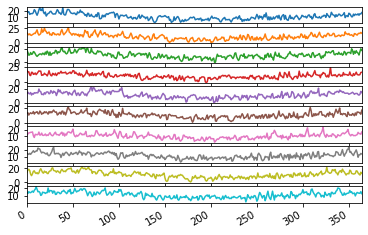

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
# load the dataset
series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# group by year 
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values

years.plot(subplots=True, legend=False)
plt.show()



Some linear time series forecasting methods assume a well-behaved distribution of observations such as a normal distribution.  
This distribution can be visualized in a histogram plot.  Create a histogram plot of the observations in the Minimum Daily
Temperatures dataset. 


<Figure size 432x288 with 0 Axes>

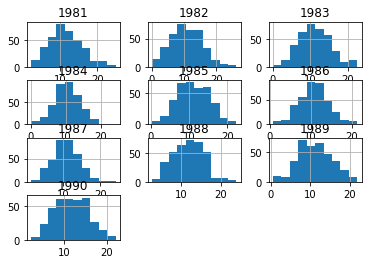

In [3]:
#
# Your code goes here 
#
plt.figure()
years.hist()
plt.show()

Boxplots can also summarize the distribution of observations. This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Outliers outside the whiskers or extents of the data are represented by dots.  Created boxplots for the temperature distribution for each year using the boxplot() function in pandas. 

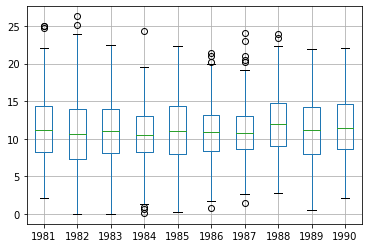

In [4]:
#
# Your code goes here 
# 
plt.figure()
years.boxplot()
plt.show()

We can create boxplots for each month in a year. The code below extracts only observations from the year 1985. Then, the observations are grouped by month, and each month is added to a new DataFrame as a column. Contruct a new DataFrame with the month-columns (months_col) and create a boxplot.  


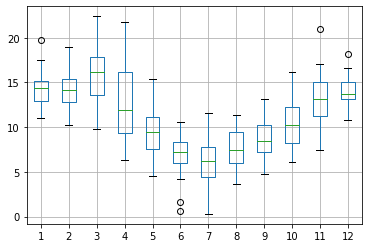

In [5]:
one_year = series['1985']
groups = one_year.groupby(pd.Grouper(freq='M'))
months_col = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)

# 
# Your code goes here 
#
months = pd.DataFrame(months_col)
months.columns = range(1,13)
months.boxplot()
plt.show()

We can also create heatmaps of the temperature. A heatmap is a matrix of numbers which as plotted as a surface (or raster). The values of each cell in the matrix is assigned a unique color. The following code create a heatmap of the temperature where each row represents one year and each column represents one day. Create a heatmap of where each row represents one day and each column represents one month 

<Figure size 432x288 with 0 Axes>

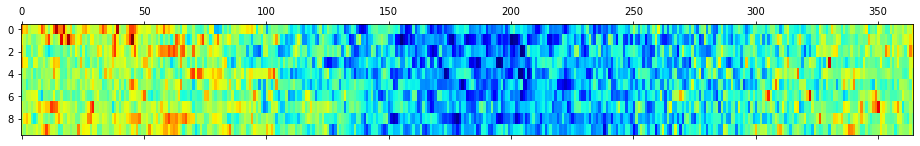

<Figure size 432x288 with 0 Axes>

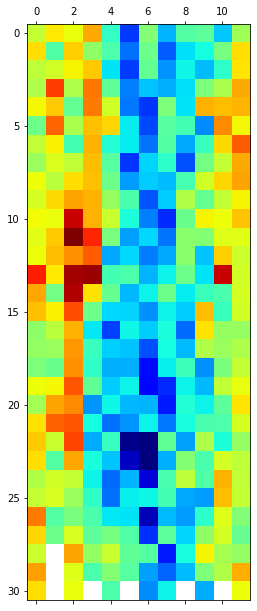

In [7]:
plt.figure()
yearsT = years.T
plt.matshow(yearsT, interpolation=None, aspect='auto',cmap='jet')
#
# Your code goes here 
#


plt.figure()
plt.matshow(months, interpolation=None, aspect='auto',cmap='jet')


Lag plots explore the relationship between each observation and a lag of that observation in a scatter plot. Pandas has a built-in function for exactly this called the lag plot. In a single figure create 7 lag plots, for a lag of 1,2,3,4,5,6 and 7 days. (Hint, use the subplot function) 

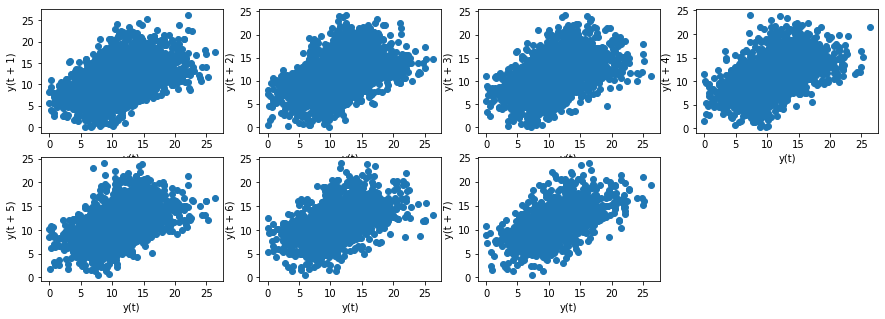

In [16]:
#
# Create a lag plot for each year in a subplot 
# Your code goes here 
# 
import numpy as np
plt.figure(figsize=(15,5))
for i in np.arange(1,8,1):
    plt.subplot(2,4,i)
    pd.plotting.lag_plot(yearsT,lag=i)

A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. 
The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.

The plot is helpful to spot obvious departures from this expectation. The code below creates a Q-Q plot of the residual errors 
with the daily-total-female-births dataset. 

In [ ]:
# qq plot of residual errors

import numpy
from statsmodels.graphics.gofplots import qqplot
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = numpy.array(residuals)
qqplot(residuals, line='r')
plt.show()

Autocorrelation calculates the strength of the relationship between an observation and observations at prior time steps. 
Create an autocorrelation plot with the residual error time series. Are they any correlations.  

In [ ]:
#
# Your code goes here 
# 
residuals = pd.DataFrame(residuals)
pd.plotting.autocorrelation_plot(residuals)

# 2. Advanced Level: Semivariograms and Kriging

The semivariogram encodes data about spatial variance over the region at a given distance or lag. It is expected that data points that are close together spatially to share other characteristics, and points that are separated by greater distances to have lesser correlation. 

For more information about semivariograms and variograms: See Variograms.pdf 

The example data consist of vertically averaged porosity values, in percent, in Zone A of the Big Bean Field (fictitious, but based on data from a real field). Porosity values are available from 85 wells distributed throughout the field, which is approximately 20 km in east-west extent and 16 km north-south. The porosities range from 12% to 17%. The following code loads the data and displays the data in a scatterplot. 

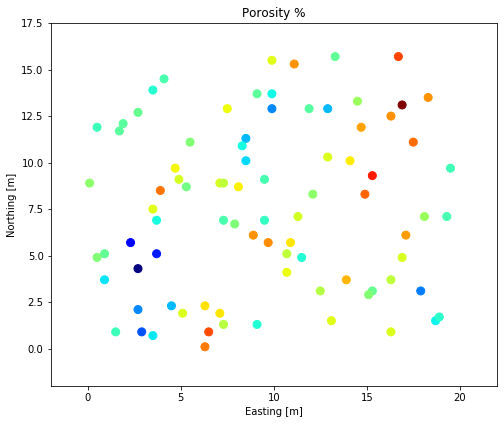

In [18]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm 
cluster_file = 'ZoneA.dat'
column_names = ["x", "y", "thk", "por", "perm", "log-perm", "log-perm-prd", "log-perm-rsd"]
z = pd.read_csv(cluster_file, sep=" ", skiprows=10, names=column_names)
P = np.array(z[['x','y','por']])

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.scatter(z.x/1000, z.y/1000, c=z.por, s=64, cmap='jet')
ax.set_aspect(1)
plt.xlim(-2, 22)
plt.ylim(-2, 17.5)

plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
th=plt.title('Porosity %')

Verify that the data is normally distributed by displaying a histogram plot and fitting and displaying a normal distribution over the histogram plot. An example plot is shown below: 

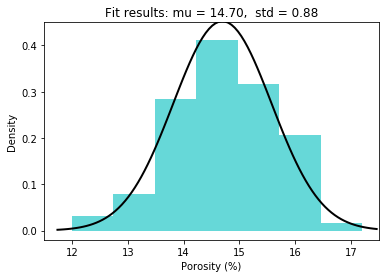

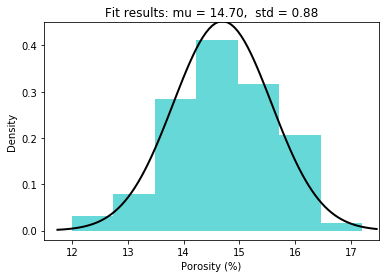

In [19]:
#
# Your code goes here 
#
hrange = (12, 17.2)
mu, std = norm.fit(z.por)
ahist=plt.hist(z.por, bins=7, density=True, alpha=0.6, color='c', range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
th=plt.title(title)
xh=plt.xlabel('Porosity (%)')
yh=plt.ylabel('Density')
xl=plt.xlim(11.5, 17.5)
yl=plt.ylim(-0.02, 0.45)

The code below shows a normal quantile-quantile plot (qqplot). The plot shows that the porosity distribution does not deviate too severely from normality. 

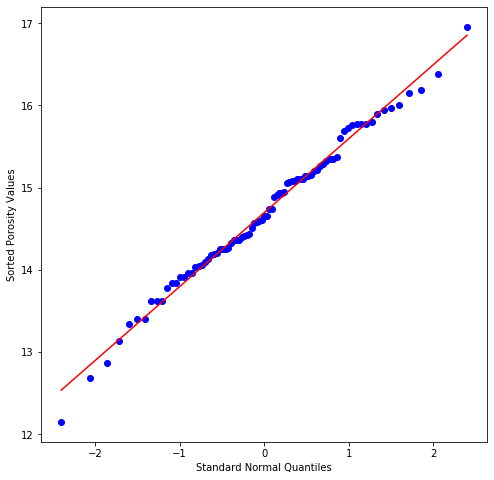

In [20]:
import scipy.stats as stats
qqdata = stats.probplot(z.por, dist="norm", plot=plt, fit=False)
xh=plt.xlabel('Standard Normal Quantiles')
yh=plt.ylabel('Sorted Porosity Values')
fig=plt.gcf()
fig.set_size_inches(8, 8)
th=plt.title('')

The following code calculates the pairwise distances between two points. The code thens selects the coordinates in a given lag +/- tolerance. We can visualize the lag in a scatterplot. Compute the autocorrelation. Increase the lag to 1000, 2000, 4000 and 8000.  At what point is there autocorrelation negligible?   

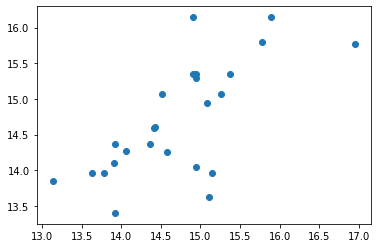

In [21]:
lag = 500
tol = 500

# Calculates the pairwise distances between two points
pwdist = squareform(pdist(P[:,:2]))
# grab the coordinates in a given range: lag +/- tolerance
i, j = np.where((pwdist >= lag - tol) & (pwdist < lag + tol))
# lagindices(pwdist, lag, tol)
# take out the repeated elements,
# since p is a *symmetric* distance matrix
indices=np.c_[i, j][np.where(j > i)]

plt.scatter(P[indices[:, 0],2],P[indices[:, 1],2])

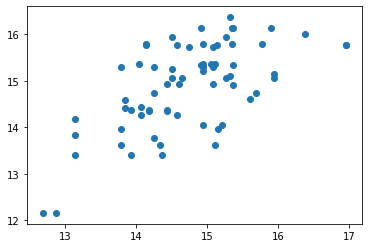

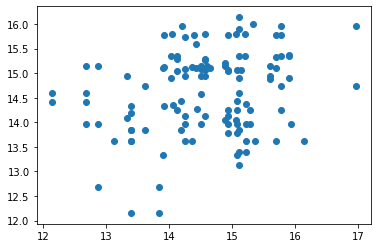

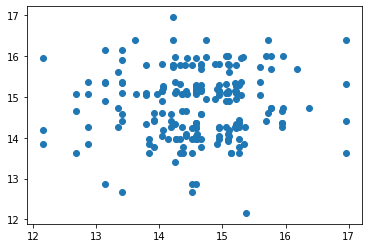

In [23]:
#
# Your code goes here 
#
lag = 1000
# Calculates the pairwise distances between two points
pwdist = squareform(pdist(P[:,:2]))
# grab the coordinates in a given range: lag +/- tolerance
i, j = np.where((pwdist >= lag - tol) & (pwdist < lag + tol))
indices=np.c_[i, j][np.where(j > i)]
plt.figure()

plt.scatter(P[indices[:, 0],2],P[indices[:, 1],2])


lag = 2000
# Calculates the pairwise distances between two points
pwdist = squareform(pdist(P[:,:2]))
# grab the coordinates in a given range: lag +/- tolerance
i, j = np.where((pwdist >= lag - tol) & (pwdist < lag + tol))
indices=np.c_[i, j][np.where(j > i)]
plt.figure()

plt.scatter(P[indices[:, 0],2],P[indices[:, 1],2])

lag = 4000
# Calculates the pairwise distances between two points
pwdist = squareform(pdist(P[:,:2]))
# grab the coordinates in a given range: lag +/- tolerance
i, j = np.where((pwdist >= lag - tol) & (pwdist < lag + tol))
indices=np.c_[i, j][np.where(j > i)]
plt.figure()
plt.scatter(P[indices[:, 0],2],P[indices[:, 1],2])

# Autocorrelation is neglible ata lag of 4000 

Create a scatterplot of each pairwise point and the difference in porosity in those points. Display your results and label the x axis and y axis. An example is shown below: 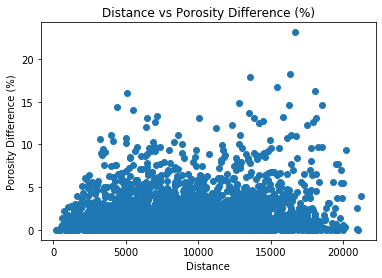

(85, 2)


Text(0, 0.5, 'Porosity Difference (%)')

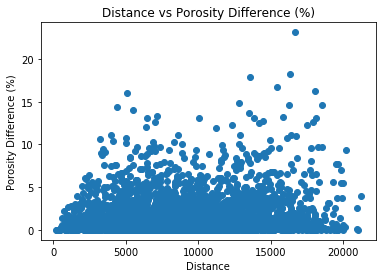

In [24]:
#
# Your code goes here 
#
# where you plot the variance for each point for each thing
distance= []
por_diff = []
psize = P[:,:2].shape
print(psize)

for i in np.arange(0,psize[0],1):
    for j in np.arange(i+1,psize[0],1):
        diffx = P[i,:][0] - P[j,:][0]
        diffy = P[i,:][1] - P[j,:][1]
        diffpor = P[i,:][2] - P[j,:][2]
        distance.append(np.sqrt(diffx*diffx + diffy*diffy))
        por_diff.append(diffpor*diffpor)

plt.scatter(distance,por_diff)
plt.title('Distance vs Porosity Difference (%)')
plt.xlabel('Distance')
plt.ylabel('Porosity Difference (%)')

The following two function creates lag indices and calculates the mean semivariance for each group of points. 

In [25]:
def lagindices(pwdist,lag,tol):
    # grab the coordinates in a given range: lag +/- tolerance
    i, j = np.where((pwdist >= lag - tol) & (pwdist < lag + tol))
    # take out the repeated elements,
    # since p is a *symmetric* distance matrix
    indices=np.c_[i, j][np.where(j > i)]
    return indices

def semivariance(data, indices):
    z=(data[indices[:, 0], 2] - data[indices[:, 1], 2])**2.0
    return np.mean(z) / 2.0

The following code computes and plots semivariance at each lag.   

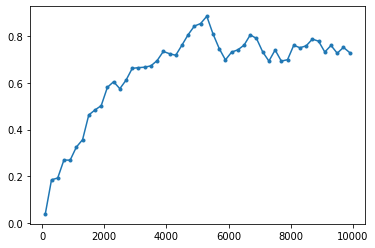

In [26]:
tolerance = 100
lags = np.arange(tolerance, 10000, tolerance*2)
pwdist = squareform(pdist(P[:,:2]))

# create a list of lists of indices of points having the ~same lag
index = [lagindices(pwdist, lag, tol) for lag in lags]
# remove indexs which are empty 
index = list(filter(lambda x: len(x) > 0, index))
     
v = [semivariance(P, indices) for indices in index]


plt.figure()
plt.plot(lags,v,'.-')


The following code fits a variogram model over the data. From the figure above, it appears that the semivariogram levels off around 4000, so we can set the range to 4000.  

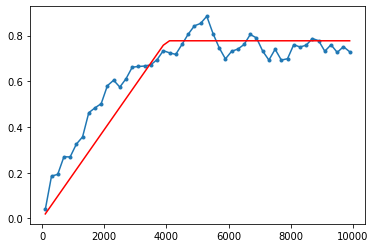

In [27]:
import variogram_model as model
sill = np.var(P[:, 2])
variogram_model1 = model.semivariance(model.linear, [4000, sill])

plt.figure()
plt.plot(lags,v,'.-')
plt.plot(lags, variogram_model1(lags), 'r')

Try different variograms model. (e.g. model.spherical, model.exponential, model.gaussian).
Which variograms model, based on your visual inspection, has the best fit? 

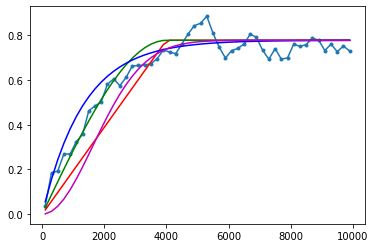

In [28]:
#
# Your code goes here 
#

variogram_model1 = model.semivariance(model.linear, [4000, sill])
variogram_model2 = model.semivariance(model.spherical, [4000, sill])
variogram_model3 = model.semivariance(model.exponential, [4000, sill])
variogram_model4 = model.semivariance(model.gaussian, [4000, sill])


plt.plot(lags,v,'.-')
plt.plot(lags, variogram_model1(lags), 'r')
plt.plot(lags, variogram_model2(lags), 'g')
plt.plot(lags, variogram_model3(lags), 'b')
plt.plot(lags, variogram_model4(lags), 'm')

Kriging is a set of techniques for interpolation. It differs from other interpolation techniques in that it sacrifices smoothness for the integrity of sampled points. Most interpolation techniques will over or undershoot the value of the function at sampled locations, but kriging honors those measurements and keeps them fixed. The following code runs kriging. 

In [ ]:
import kriging as kriging
# using kriging to interpolate between the images
covfct = model.covariance(model.spherical, (4000, sill))

kriging.simple(P, covfct, [2000, 4700], N=6)

# 3. Advanced Level: Spatiotemporal Visualization of Raster Data.

We will use the Tropical Pacific Sea Surface Temperature (SST) Anomalies dataset for spatiotemporal visualization. These data represent gridded monthly SST anomalies for 399 consecutive months from January 1970 through March 2003. The data were obtained from the IRI/LDEO Climate Data Library at Columbia University (http://iridl.ldeo.columbia.edu/). The data are gridded at a 2 degree by 2 degree resolution and represent anomalies from a January 1970 - December 1985 monthly (average) climatology. 

The dataset consists of 
* SSTlonlat.dat: 2520 x 2 matrix; longitude in first column and latitude in the second, corresponding to the spatial grid locations in SST011970_032003.dat; note: the longitudes are given from 124 to 290 by 2, corresponding to 124E to 290E (where 290E corresponds to 70W). 
* SST011970_032003.dat 2520 x 399 matrix; 2520 spatial locations corresponding to an 84 (longitude) by 30 (latitude) grid with 2 deg x 2 deg spacing. The longitudes correspond to 124 E to 70W and the latitudes to 29S to 29N. There are 399 time periods representing sequentially the months from January 1970 through March 2003. 
* SSTlandmask.dat 2520 x 1 vector; land/sea mask corresponding to the grid locations in SSTlonlat.dat, with a value of 1 corresponding to a "land" location and a 0 corresponding to a water location.

1. Load the dataset, SST011970_032003.dat. Extract the spatial locations for the last 60 time periods. 
2. Visualize the data in a Howmoller plot.
3. Create a gif to visualize the change the sea surface temperature. Overly your image with the land/sea mask.  

In [ ]:
#
# Your code goes here 
#